In [1]:
import argparse
import numpy as np
import os
import torch
import tifffile as tiff

from video_depth_anything.video_depth import VideoDepthAnything
from utils.dc_utils import read_video_frames, save_video
from torchinfo import summary
from torchvision.transforms import Compose
from video_depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet
import cv2
from thop import profile
import torch.profiler as profiler
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from einops import rearrange
import imageio

from video_depth_anything.video_depth import INFER_LEN

In [5]:
class Arguments():
    def __init__(self, device, input_video='/export/data/ffeiden/data/vkitti_videos/gt_vids/Scene01_clone_Camera_0.mp4',
                 output_dir='./outputs', input_size=518, max_res=1280, encoder='vitl', max_len=-1,
                 target_fps=-1, fp32=False, calc_time=False, calc_computation=False):
        self.device = device
        self.input_video = input_video
        self.output_dir = output_dir
        self.input_size = input_size
        self.max_res = max_res
        self.encoder = encoder
        self.max_len = max_len
        self.target_fps = target_fps
        self.fp32 = fp32
        self.calc_time = calc_time
        self.calc_computation = calc_computation 


args = Arguments('cuda:4')

In [6]:
def prepare_data(frames, target_fps, input_size=518, device='cuda', fp32=False, start_frame=0, new_frames=1):
    '''
    prepares data for input into the network and pushes it to device. 

    returns: cur_input (batch of 32 frames)
             next_input (batch of 32 frames starting with start_frame + new_frames)
    '''
    frame_height, frame_width = frames[0].shape[:2]
    ratio = max(frame_height, frame_width) / min(frame_height, frame_width)
    if ratio > 1.78:  # we recommend to process video with ratio smaller than 16:9 due to memory limitation
        input_size = int(input_size * 1.777 / ratio)
        input_size = round(input_size / 14) * 14

    transform = Compose([
        Resize(
            width=input_size,
            height=input_size,
            resize_target=False,
            keep_aspect_ratio=True,
            ensure_multiple_of=14,
            resize_method='lower_bound',
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        PrepareForNet(),
    ])

    frame_list = [frames[i] for i in range(frames.shape[0])]
    cur_list = []
    next_list = []
    for i in range(INFER_LEN):
        cur_list.append(torch.from_numpy(transform({'image': frame_list[start_frame+i].astype(np.float32) / 255.0})['image']).unsqueeze(0).unsqueeze(0))
        next_list.append(torch.from_numpy(transform({'image': frame_list[start_frame+new_frames+i].astype(np.float32) / 255.0})['image']).unsqueeze(0).unsqueeze(0))
    cur_input = torch.cat(cur_list, dim=1).to(device)
    next_input = torch.cat(next_list, dim=1).to(device)
    return cur_input, next_input

def visualize_feature_maps(batch, frame, fig_path, video_batch = 0, height=None, width=None):
    '''
    :param batch: torch.Tensor shape (video_b, embed_dim, frame_b, height, width)
    :type batch: torch.Tensor
    :param fig_path: filepath to save the figure. It will overwrite without asking
    :type fig_path: str
    :param frame: index of the frame to analyze 
    :type frame: int
    '''
    video_b, embed_dim, frame_b, height_, width_ = batch.size()
    height = height_
    width = width_

    frame = batch[video_batch, :, frame, :, :]

    frame = rearrange(frame, 'e h w -> (h w) e').detach().cpu().numpy()
    
    pca = PCA(n_components=3)
    # In case everything is 0 
    if np.abs(frame.sum()) > 0.: 
        principle_comp = pca.fit_transform(frame)
    else:
        principle_comp = frame[:, :3].astype(np.float32)

    principle_comp = rearrange(principle_comp, '(h w) e -> h w e', h=height, w=width)

    # Clamp Data to plot only positiv height values 
    # This might introduce a bias for the visualisation
    # lower_val = np.percentile(principle_comp, 0.8) # Only look at heighest 80%
    # principle_comp = np.clip(principle_comp, a_min=lower_val, a_max=principle_comp.max())

    principle_comp = (principle_comp - principle_comp.min()) / (principle_comp.max() - principle_comp.min() + 1e-8)

    plt.imshow(principle_comp)
    plt.show()
    return principle_comp


In [7]:
DEVICE = args.device if torch.cuda.is_available() else 'cpu'

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
}
# Default model to check if everything is working
video_depth_anything = VideoDepthAnything(**model_configs[args.encoder])
video_depth_anything.load_state_dict(torch.load(f'./checkpoints/video_depth_anything_{args.encoder}.pth', map_location='cpu'), strict=True)
video_depth_anything = video_depth_anything.to(DEVICE).eval()

# frames: [447, 374, 1242, 3] [frames, height, width, channels] in range 0, 255 type uint8
frames, target_fps = read_video_frames(args.input_video, args.max_len, args.target_fps, args.max_res)

cur_input, next_input = prepare_data(frames, target_fps, input_size=args.input_size, device=DEVICE, fp32=args.fp32)

In [8]:
# Create Hooks to Analyze the model easier
features = {}
def get_feature(name):
    def hook(model, input, output):
        features[name+'_input'] = input
        features[name+'_output'] = output
    return hook

def get_pos_Encoding(name):
    def hook(model, input, output):
        features[name] = model.pe
    return hook

hooks = {}
for i in range(len(video_depth_anything.head.motion_modules)):
    hooks[f'tmp{i}'] = video_depth_anything.head.motion_modules[i].register_forward_hook(get_feature(f'tmp{i}'))
    hooks[f'posEnc{i}'] = video_depth_anything.head.motion_modules[i].temporal_transformer.transformer_blocks[0].attention_blocks[0].pos_encoder.register_forward_hook(get_pos_Encoding(f'posEnc{i}'))

posEnc0


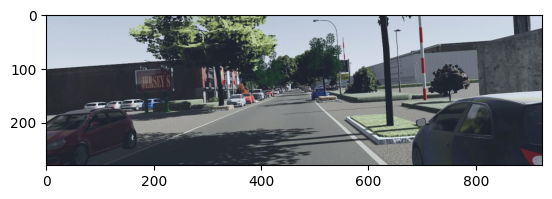

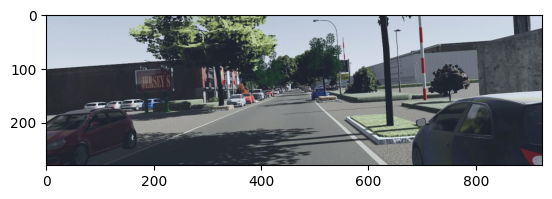

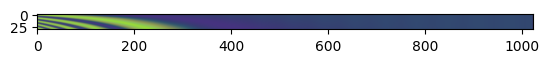

tmp0_input


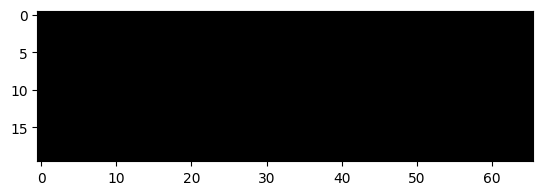

tmp0_output


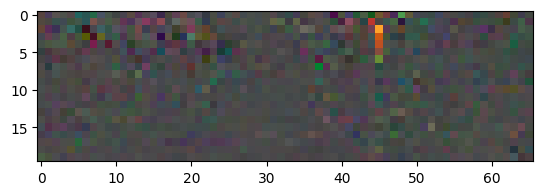

posEnc1


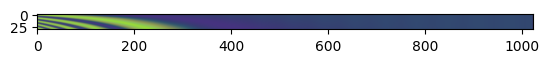

tmp1_input


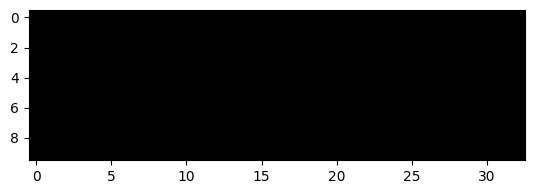

tmp1_output


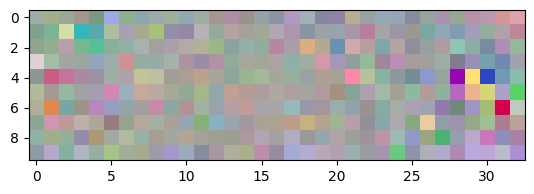

posEnc2


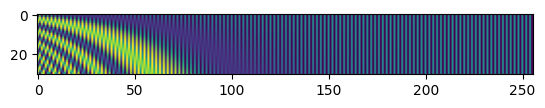

tmp2_input


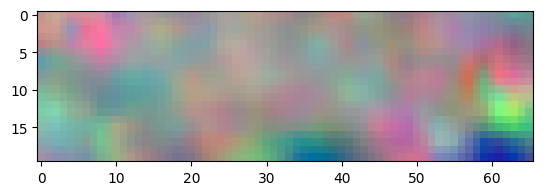

tmp2_output


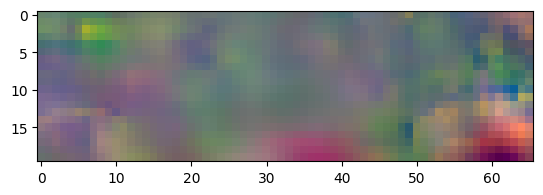

posEnc3


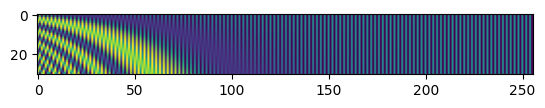

tmp3_input


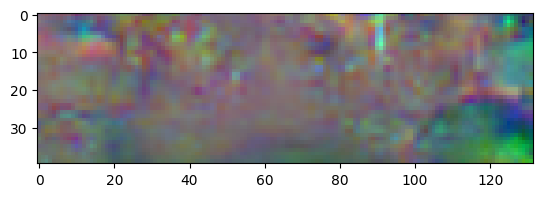

tmp3_output


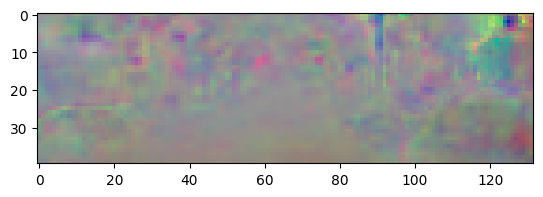

In [20]:
# Get intermediate representations of Network
with torch.no_grad(): 
        with torch.autocast(device_type=args.device, enabled=(not args.fp32)):
            cur_pred = video_depth_anything(cur_input)
            cur_features = features.copy()

with torch.no_grad(): 
        with torch.autocast(device_type=args.device, enabled=(not args.fp32)):
            next_pred = video_depth_anything(next_input)
            next_features = features.copy()

# Visualise Features
orig_plottet = False
for name in cur_features:
    print(name)
    frame = 14
    if 'tmp' in name:
        feature_num = int(name.split('tmp')[-1].split('_')[0])
    if 'posEnc' in name:
        feature_num = int(name.split('posEnc')[-1].split('_')[0])
    
    if not orig_plottet:
        orig_img = cur_input[0, frame, :, :, :].detach().cpu().numpy()
        orig_img = (orig_img - orig_img.min()) / (orig_img.max() - orig_img.min())
        orig_img = rearrange(orig_img, 'c h w -> h w c')

        plt.imshow(orig_img)
        plt.show()


        orig_img = next_input[0, frame-1, :, :, :].detach().cpu().numpy()
        orig_img = (orig_img - orig_img.min()) / (orig_img.max() - orig_img.min())
        orig_img = rearrange(orig_img, 'c h w -> h w c')
        plt.imshow(orig_img)
        plt.show()
        orig_plottet=True

    cur_save_vis = 'tmp/curr_' + name + f'_frame{frame}.png'
    next_save_vis = 'tmp/next_' + name + f'_frame{frame-1}.png'
    diff_save_vis = 'tmp/diff_' + name + f'_frame{frame-1}.png'

    if 'tmp' in name:
        if 'input' in name:
            #cur_vis = visualize_feature_maps(cur_features[name][0], frame=frame, fig_path=cur_save_vis)
            #next_vis = visualize_feature_maps(next_features[name][0], frame=frame-1, fig_path=next_save_vis)
            diff = cur_features[name][0][:, :, 1:, :, :] - next_features[name][0][:, :, :-1, :, :]
            diff_vis = visualize_feature_maps(diff, frame=frame-1, fig_path=diff_save_vis)
        else:
            #cur_vis = visualize_feature_maps(cur_features[name], frame=frame, fig_path=cur_save_vis)
            #next_vis = visualize_feature_maps(next_features[name], frame=frame-1, fig_path=next_save_vis)
            diff = cur_features[name][:, :, 1:, :, :] - next_features[name][:, :, :-1, :, :]
            diff_vis = visualize_feature_maps(diff, frame=frame-1, fig_path=diff_save_vis)
    elif 'posEnc' in name:
        _, _, _,height, width = cur_features[f'tmp{feature_num}_output'].size()
        pos_enc = cur_features[name][:, 1:, :]
        pos_enc = (pos_enc - pos_enc.min()) / (pos_enc.min() - pos_enc.max() + 1e-8)
        plt.imshow(pos_enc[0].detach().cpu().numpy())
        plt.show()



In [12]:
cur_features['posEnc0'].size()

torch.Size([1, 32, 1024])

In [7]:
# Unhook the features hook
for key in hooks:
    hooks[key].remove()

In [ ]:
# Profile Time used 
if args.calc_time:
    with profiler.profile(activities=[
                                profiler.ProfilerActivity.CPU,
                                profiler.ProfilerActivity.CUDA
                                    ]) as prof:
        with torch.no_grad(): 
            with torch.autocast(device_type=args.device, enabled=(not args.fp32)):
                for i in tqdm(range(10)):
                    _ = video_depth_anything.forward(cur_input)
    print(prof.key_averages().table(sort_by="self_cuda_time_total"))

In [ ]:
# Measre computations
if args.calc_computation:
    with torch.no_grad(): 
        with torch.autocast(device_type=args.device, enabled=(not args.fp32)):
            macs, params = profile(video_depth_anything, inputs=(cur_input, ))
            B, T, C, H, W = cur_input.shape
            patch_h, patch_w = H // 14, W // 14
            macs_Head, params_Head = profile(video_depth_anything.head,
                                                inputs=(video_depth_anything.pretrained.get_intermediate_layers(cur_input.flatten(0,1),
                                                        video_depth_anything.intermediate_layer_idx[video_depth_anything.encoder],
                                                        False, True, True ), patch_h, patch_w, T))
            macs_DinoV2, params_DinoV2 = profile(video_depth_anything.pretrained,
                                                inputs=(cur_input.flatten(0,1), ))

    FLOPs = macs * 2
    FLOPs_Head = macs_Head * 2
    FLOPs_DinoV2 = macs_DinoV2 * 2
    print('Complete Video Depth Anything \n --------------------- ')
    print(f'Params  : {params:.3e}')
    print(f'MACs    : {macs:.3e}')
    print(f'FLOPs   : {FLOPs:.3e} \n \n')

    print('Complete Decoder Head \n --------------------- ')
    print(f'Params  : {params_Head:.3e}')
    print(f'MACs    : {macs_Head:.3e}')
    print(f'FLOPs   : {FLOPs_Head:.3e} \n \n')

    print('Complete DinoV2 \n --------------------- ')
    print(f'Params  : {params_DinoV2:.3e}')
    print(f'MACs    : {macs_DinoV2:.3e}')
    print(f'FLOPs   : {FLOPs_DinoV2:.3e} \n \n')

    macs_UsedDinoV2 = macs - macs_Head
    FLOPs_UsedDinoV2 = macs_UsedDinoV2 * 2
    params_UsedDinoV2 = params - params_Head

    print('Used DinoV2 \n --------------------- ')
    print(f'Params  : {params_UsedDinoV2:.3e}')
    print(f'MACs    : {macs_UsedDinoV2:.3e}')
    print(f'FLOPs   : {FLOPs_UsedDinoV2:.3e} \n \n')
